### Universidade Federal de Viçosa - Campus Rio Paranaíba

### Professor Rodrigo Smarzaro

### Ciência de Dados Geoespacial

### Projeto final da disciplina

> Autor: Viviane Renizia Mendes Silva

> Matrícula: 5209

# Essa primeira célula importa as bibliotecas necessárias para o código. Aqui, estamos importando as bibliotecas pandas, folium, MarkerCluster do pacote folium.plugins, unidecode, seaborn, geopandas, numpy, matplotlib.pyplot e Patch do pacote matplotlib.

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from unidecode import unidecode
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Essa linha é uma magic function do Jupyter Notebook, que define a exibição dos gráficos do matplotlib diretamente no notebook, em vez de abrir uma nova janela.
%matplotlib inline
# Essa linha define uma opção do pandas para exibir até 100 colunas ao imprimir um DataFrame. Isso é útil quando temos um DataFrame com muitas colunas e queremos visualizar todas elas.
pd.set_option('display.max_columns', 100)

# Essas linhas carregam os conjuntos de dados de vários arquivos CSV e armazenam os dados nos respectivos DataFrames. Os conjuntos de dados carregados incluem informações de clientes, geolocalização, itens de pedido, pagamentos, avaliações, pedidos, produtos, vendedores e tradução de nomes de categorias de produtos.

In [ ]:
customers = pd.read_csv('input/olist_customers_dataset.csv')
geo = pd.read_csv('input/olist_geolocation_dataset.csv')
items = pd.read_csv('input/olist_order_items_dataset.csv').drop(columns=['shipping_limit_date'])
payments = pd.read_csv('input/olist_order_payments_dataset.csv')
reviews = pd.read_csv('input/olist_order_reviews_dataset.csv').drop(columns=['review_id','review_creation_date','review_answer_timestamp'])
orders = pd.read_csv('input/olist_orders_dataset.csv')
products = pd.read_csv('input/olist_products_dataset.csv').drop(columns=['product_name_lenght','product_length_cm', 'product_height_cm', 'product_width_cm'])
sellers = pd.read_csv('input/olist_sellers_dataset.csv')
translation = pd.read_csv('input/product_category_name_translation.csv')

# Essas linhas adicionam informações de geolocalização aos dados dos clientes. Os dados de geolocalização são combinados com os dados dos clientes usando os códigos postais (zip codes) e os dados resultantes são renomeados e armazenados novamente no DataFrame "customers".

In [ ]:
customers = pd.merge(customers, geo, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
customers = customers.rename(columns={'geolocation_lat':'customer_lat', 'geolocation_lng':'customer_lng'})
customers['customer_city'] = customers['geolocation_city']
customers['customer_state'] = customers['geolocation_state']
customers = customers.drop(columns=['geolocation_city', 'geolocation_state', 'customer_zip_code_prefix', 'geolocation_zip_code_prefix'])
customers = customers[customers.duplicated(subset=['customer_id'])]

# Essas linhas adicionam informações de geolocalização aos dados dos vendedores. Os dados de geolocalização são combinados com os dados dos vendedores usando os códigos postais (zip codes)

In [ ]:
sellers = pd.merge(sellers, geo, how='left', left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
sellers = sellers.rename(columns={'geolocation_lat':'seller_lat', 'geolocation_lng':'seller_lng'})
sellers['seller_city'] = sellers['geolocation_city']
sellers['seller_state'] = sellers['geolocation_state']
sellers = sellers.drop(columns=['geolocation_city', 'geolocation_state', 'seller_zip_code_prefix', 'geolocation_zip_code_prefix'])
sellers = sellers[sellers.duplicated(subset=['seller_id'])]

# Essas linhas realizam várias etapas de junção e tratamento nos conjuntos de dados, exceto para o DataFrame "sellers".

In [ ]:
# Essa linha combina (faz um merge) os DataFrames "orders" e "customers" com base na coluna "customer_id". Os dados são armazenados no DataFrame "df".
df = pd.merge(orders, customers, how='left', on='customer_id')
# Essa linha remove as duplicatas com base nas colunas "order_id" e "customer_unique_id" do DataFrame "df". Isso garante que cada ordem de compra seja representada apenas uma vez.
df = df.drop_duplicates(subset=['order_id', 'customer_unique_id'])
df = pd.merge(df, payments, how='left', on='order_id')
df = df.drop_duplicates(subset=['order_id', 'customer_unique_id'])
df = pd.merge(df, reviews, how='left', on='order_id')
df = df.drop_duplicates(subset=['order_id', 'customer_unique_id'])
df = pd.merge(df, items, how='left', on='order_id')
df = df.drop_duplicates(subset=['order_id', 'customer_unique_id'])
df = pd.merge(df, products, how='left', on='product_id')
df = df.drop_duplicates(subset=['order_id', 'customer_unique_id'])
df = pd.merge(df, sellers, how='left', on='seller_id')
df = df.drop_duplicates(subset=['order_id', 'customer_unique_id'])

# Essas linhas removem as colunas 'payment_sequential', 'payment_type' e 'payment_installments' do DataFrame "df".
# Em seguida, é criada uma nova coluna chamada 'transaction' que contém a soma dos valores das colunas 'price' e 'freight_value'.
df = df.drop(columns=['payment_sequential', 'payment_type', 'payment_installments'])
df['transaction'] = df['price'] + df['freight_value']

# Essa linha filtra o DataFrame "df" para manter apenas as linhas onde as coordenadas dos clientes ('customer_lat' e 'customer_lng')
# e dos vendedores ('seller_lat' e 'seller_lng') estão dentro das faixas geográficas específicas correspondentes ao território do Brasil.
df = df[(df['customer_lat'] <= 5.27438888) &
        (df['customer_lng'] >= -73.98283055) &
        (df['customer_lat'] >= -33.75116944) &
        (df['customer_lng'] <= -34.79314722) &
        (df['seller_lat'] <= 5.27438888) &
        (df['seller_lng'] >= -73.98283055) &
        (df['seller_lat'] >= -33.75116944) &
        (df['seller_lng'] <= -34.79314722)]

# Essas linhas combinam o DataFrame "df" com o DataFrame "translation" com base na coluna "product_category_name".
# Isso é feito para adicionar a tradução dos nomes das categorias de produtos. Em seguida, o índice do DataFrame é redefinido.
df = pd.merge(df, translation, how='inner', on='product_category_name')
df = df.reset_index(drop=True)

# Essas linhas exibem informações sobre o DataFrame "df". O formato (shape) do DataFrame é impresso, seguido de informações adicionais
# sobre as colunas e o tipo de dados. Por fim, as primeiras linhas do DataFrame são exibidas.
print(df.shape)
print(df.info())
df.head()

(96239, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96239 entries, 0 to 96238
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       96239 non-null  object 
 1   customer_id                    96239 non-null  object 
 2   order_status                   96239 non-null  object 
 3   order_purchase_timestamp       96239 non-null  object 
 4   order_approved_at              96226 non-null  object 
 5   order_delivered_carrier_date   95271 non-null  object 
 6   order_delivered_customer_date  94133 non-null  object 
 7   order_estimated_delivery_date  96239 non-null  object 
 8   customer_unique_id             96239 non-null  object 
 9   customer_city                  96239 non-null  object 
 10  customer_state                 96239 non-null  object 
 11  customer_lat                   96239 non-null  float64
 12  customer_lng                   962

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,customer_lat,customer_lng,payment_value,review_score,review_comment_title,review_comment_message,order_item_id,product_id,seller_id,price,freight_value,product_category_name,product_description_lenght,product_photos_qty,product_weight_g,seller_city,seller_state,seller_lat,seller_lng,transaction,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,-23.578333,-46.587123,18.12,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,268.0,4.0,500.0,maua,SP,-23.675223,-46.441038,38.71,housewares
1,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21 00:00:00,3e4fd73f1e86b135b9b121d6abbe9597,presidente venceslau,SP,-21.872573,-51.836167,356.12,1.0,NaN,"Inicialmente, na data da compra o produto era ...",1.0,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,339.00,17.12,utilidades_domesticas,664.0,6.0,14300.0,rio do sul,SC,-27.224769,-49.647870,356.12,housewares
2,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-04-24 09:34:13,2017-05-10 09:17:55,2017-05-12 00:00:00,f9effeed3df9ae063a58c0759b96f8b2,cascavel,PR,-24.984884,-53.479099,267.80,1.0,NaN,NaN,1.0,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,38.00,15.56,utilidades_domesticas,698.0,3.0,705.0,sao paulo,SP,-23.685343,-46.685930,53.56,housewares
3,e3447938231fb6ba2fee0231b51eca59,2c3642e1392097fb4af76a76fec16a46,delivered,2018-08-26 11:04:26,2018-08-26 11:15:29,2018-08-27 15:52:00,2018-08-28 21:06:31,2018-08-30 00:00:00,08de4d9507128e2ad419e26cc4f22b65,guarujá,SP,-23.985758,-46.242992,172.14,5.0,"Produto muito bonito, gos","Produto muito bonito, chegou no prazo correto ...",1.0,97f1396a5a1f7c07ba51784efdec44b8,955fee9216a65b617aa5c0531780ce60,160.00,12.14,utilidades_domesticas,1632.0,8.0,1400.0,são paulo,SP,-23.690136,-46.704876,172.14,housewares
4,af5b0604e113e1526593d505a26ef39d,b896b244963dc7543d400ad82d6710e0,delivered,2017-09-27 12:07:22,2017-09-27 12:26:02,2017-09-29 22:25:42,2017-09-30 17:13:01,2017-10-16 00:00:00,3d8614b1f25530eca12661dc8b10a2fb,são paulo,SP,-23.605983,-46.482517,28.62,1.0,NaN,"Boa noite, não recebi o escorredor de louça, C...",1.0,978859c6048ded0fa8bf3b9ea8236387,813348c996469b40f2e028d5429d3495,19.90,8.72,utilidades_domesticas,299.0,1.0,350.0,jundiai,SP,-23.207434,-46.881160,28.62,housewares


# Essas linhas realizam uma análise sobre o número de pedidos feitos por estado.

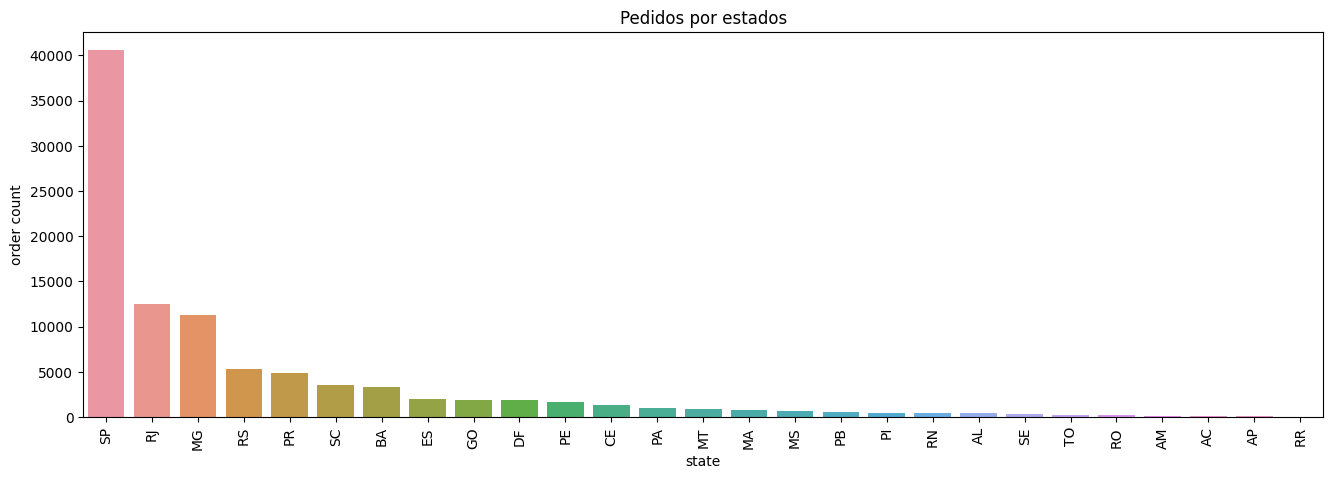

In [ ]:
# Essas linhas criam um novo DataFrame chamado "state" que contém o número de pedidos feitos por estado.
# A coluna 'customer_state' do DataFrame "df" é contada usando a função value_counts(), e os resultados são armazenados em "state".
# Em seguida, as colunas do DataFrame "state" são renomeadas para 'state' e 'order count'.
state = pd.DataFrame(df['customer_state'].value_counts()).reset_index()
state.columns = ['state', 'order count']

# Essas linhas criam um gráfico de barras utilizando a biblioteca Seaborn para visualizar o número de pedidos por estado.
# O eixo x do gráfico é definido como a coluna 'state' do DataFrame "state", enquanto o eixo y é definido como a coluna 'order count'.
# O gráfico é exibido com os estados no eixo x rotacionados em 90 graus para facilitar a leitura dos rótulos.
# O título do gráfico é definido como 'Figure 1 Customer order count by states'.
plt.figure(figsize=(16,5))
sns.barplot(x='state', y='order count', data=state)
plt.xticks(rotation=90)
plt.title('Pedidos por estados')
plt.show()

# Essas linhas realizam uma análise sobre o valor total das transações feitas por estado.

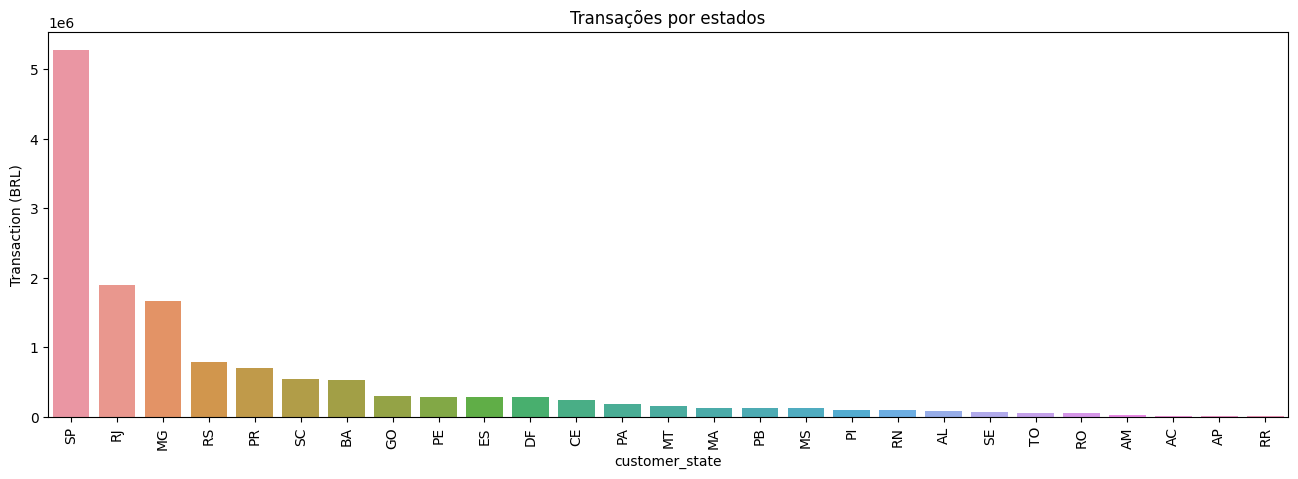

In [ ]:
# Essas linhas criam um novo DataFrame chamado "state_value" que contém o valor total das transações por estado.
# É criada uma tabela dinâmica (pivot table) usando o DataFrame "df" onde o índice é definido como 'customer_state',
# os valores são definidos como 'transaction', e a função de agregação é np.sum para somar os valores.
# Os resultados são armazenados em "state_value". Em seguida, os valores são ordenados em ordem decrescente com base na coluna 'transaction'.
# As colunas do DataFrame "state_value" são renomeadas para 'customer_state' e 'Transaction (BRL)'.
state_value = pd.pivot_table(df, index=['customer_state'], values='transaction', aggfunc=np.sum).reset_index()
state_value = state_value.sort_values(by=['transaction'], ascending=False)
state_value.columns = ['customer_state', 'Transaction (BRL)']

# Essas linhas criam um gráfico de barras utilizando a biblioteca Seaborn para visualizar o valor total das transações por estado.
# O eixo x do gráfico é definido como a coluna 'customer_state' do DataFrame "state_value", enquanto o eixo y é definido como a coluna 'Transaction (BRL)'.
# O gráfico é exibido com os estados no eixo x rotacionados em 90 graus para facilitar a leitura dos rótulos.
# O título do gráfico é definido como 'Figure 2 Customer transaction by states'.
plt.figure(figsize=(16,5))
sns.barplot(x='customer_state', y='Transaction (BRL)', data=state_value)
plt.title('Transações por estados')
plt.xticks(rotation=90)
plt.show()

# Essas linhas realizam uma análise sobre os produtos mais pedidos.

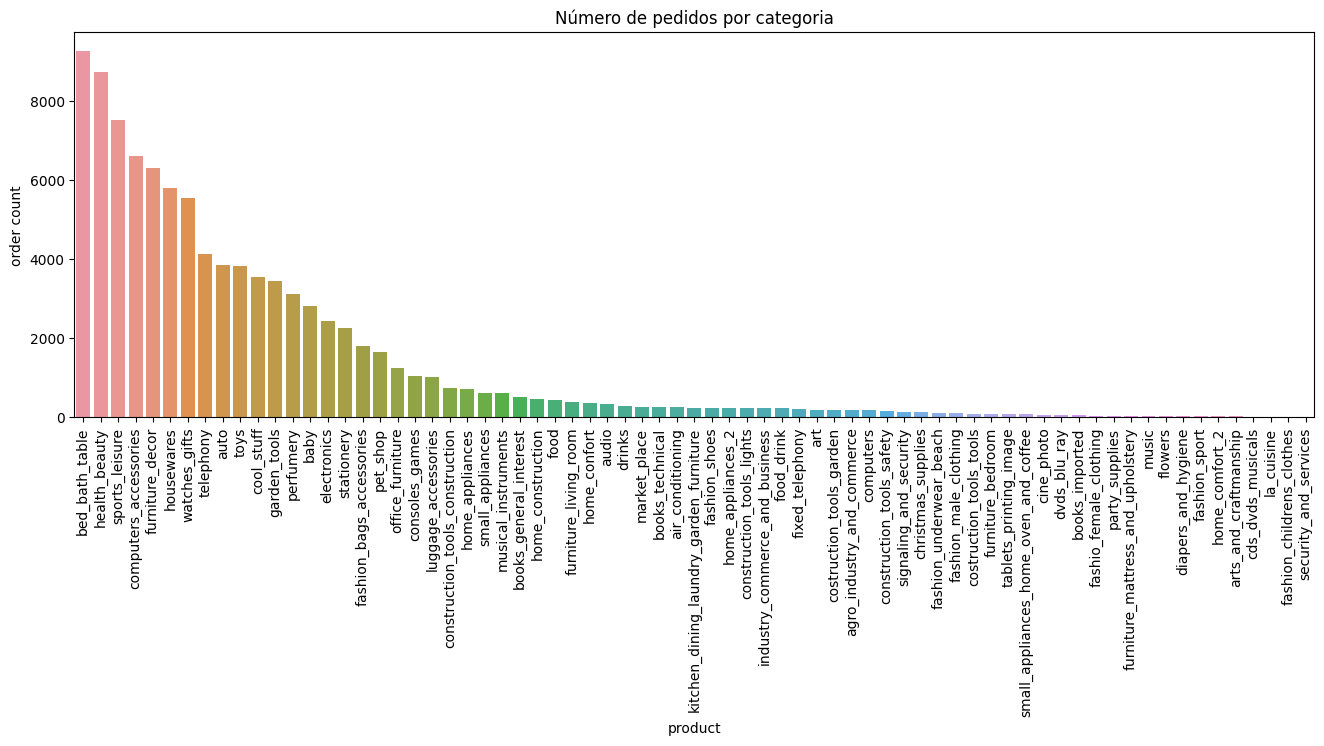

In [ ]:
# Essas linhas criam um novo DataFrame chamado "prod" que contém o número de pedidos por categoria de produto.
# A coluna 'product_category_name_english' do DataFrame "df" é contada usando a função value_counts(), e os resultados são armazenados em "prod".
# Em seguida, as colunas do DataFrame "prod" são renomeadas para 'product' e 'order count'.
prod = pd.DataFrame(df['product_category_name_english'].value_counts()).reset_index()
prod.columns = ['product', 'order count']

# Essas linhas criam um gráfico de barras utilizando a biblioteca Seaborn para visualizar o número de pedidos por categoria de produto.
# O eixo x do gráfico é definido como a coluna 'product' do DataFrame "prod", enquanto o eixo y é definido como a coluna 'order count'.
# O gráfico é exibido com as categorias de produto no eixo x rotacionadas em 90 graus para facilitar a leitura dos rótulos.
# O título do gráfico é definido como 'Figure 3 Order count by product categories'.

plt.figure(figsize=(16,5))
sns.barplot(x='product', y='order count', data=prod)
plt.xticks(rotation=90)
plt.title('Número de pedidos por categoria')
plt.show()

# Essas linhas realizam uma análise sobre o valor total das transações por categoria de produto.

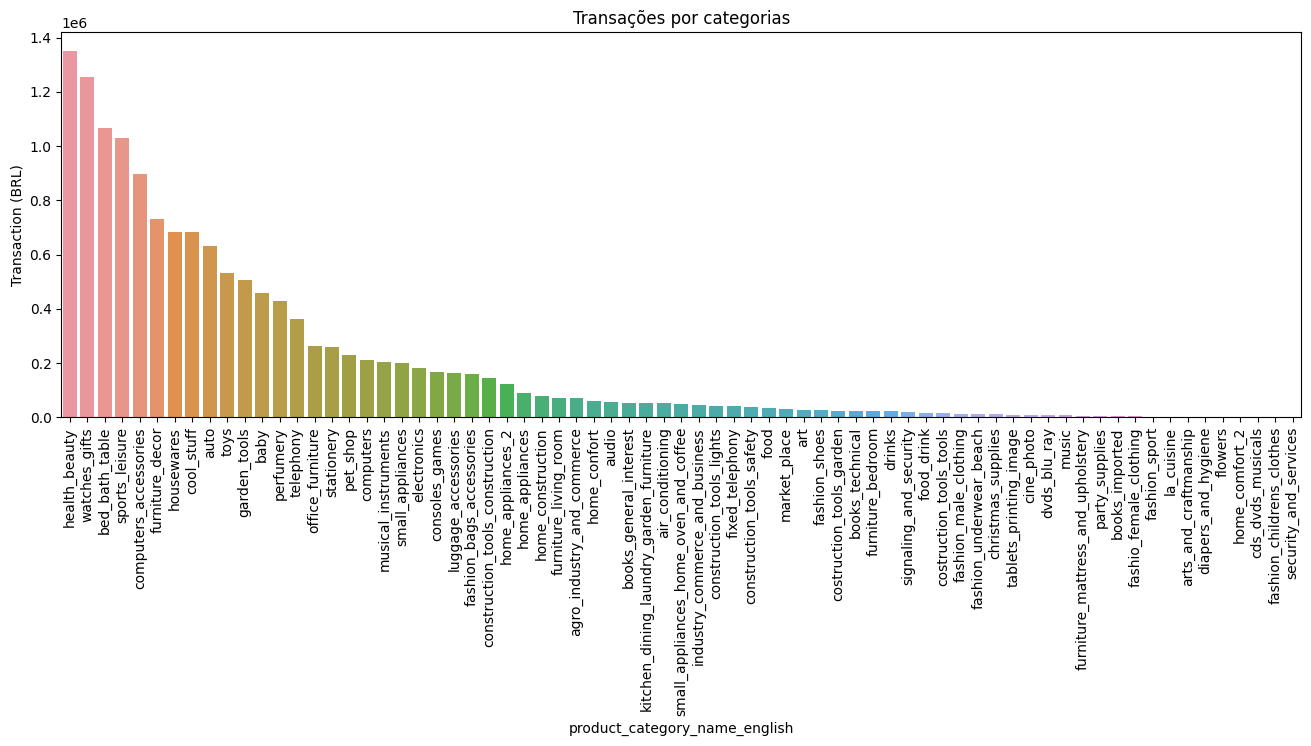

In [ ]:
# Essas linhas criam um novo DataFrame chamado "prod_value" que contém o valor total das transações por categoria de produto.
# É criada uma tabela dinâmica (pivot table) usando o DataFrame "df" onde o índice é definido como 'product_category_name_english',
# os valores são definidos como 'transaction', e a função de agregação é np.sum para somar os valores. Os resultados são armazenados em "prod_value".
# Em seguida, os valores são ordenados em ordem decrescente com base na coluna 'transaction'. As colunas do DataFrame "prod_value" são renomeadas
# para 'product_category_name_english' e 'Transaction (BRL)'.
prod_value = pd.pivot_table(df, index=['product_category_name_english'], values='transaction', aggfunc=np.sum).reset_index()
prod_value = prod_value.sort_values(by=['transaction'], ascending=False)
prod_value.columns = ['product_category_name_english', 'Transaction (BRL)']

# Essas linhas criam um gráfico de barras utilizando a biblioteca Seaborn para visualizar o valor total das transações por categoria de produto.
# O eixo x do gráfico é definido como a coluna 'product_category_name_english' do DataFrame "prod_value", enquanto o eixo y é definido como a coluna 'Transaction (BRL)'.
# O gráfico é exibido com as categorias de produto no eixo x rotacionadas em 90 graus para facilitar a leitura dos rótulos.
# O título do gráfico é definido como 'Figure 4 Transaction by product categories'.
plt.figure(figsize=(16,5))
sns.barplot(x='product_category_name_english', y='Transaction (BRL)', data=prod_value)
plt.xticks(rotation=90)
plt.title('Transações por categorias')
plt.show()

# Essa linha carrega um conjunto de dados contendo as informações geográficas dos estados do Brasil.

In [ ]:
# Essa linha utiliza a função gpd.read_file() da biblioteca GeoPandas para ler o arquivo shapefile dos estados do Brasil.
# O arquivo é obtido através de um link na internet especificado como argumento da função. O arquivo shapefile contém informações geoespaciais dos estados,
# como polígonos que representam as fronteiras dos estados. Os dados são carregados e armazenados no DataFrame "state".
state = gpd.read_file('https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_UF_2022.zip')
state.head()

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,AREA_KM2,geometry
0,12,Acre,AC,Norte,164173.429,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."
1,13,Amazonas,AM,Norte,1559255.881,"POLYGON ((-56.76292 -3.23221, -56.76789 -3.242..."
2,15,Pará,PA,Norte,1245870.704,"MULTIPOLYGON (((-48.97548 -0.19834, -48.97487 ..."
3,16,Amapá,AP,Norte,142470.762,"MULTIPOLYGON (((-51.04561 -0.05088, -51.05422 ..."
4,17,Tocantins,TO,Norte,277423.627,"POLYGON ((-48.24830 -13.19239, -48.24844 -13.1..."


# Essas linhas criam uma visualização dos pontos de localização dos clientes em um mapa.

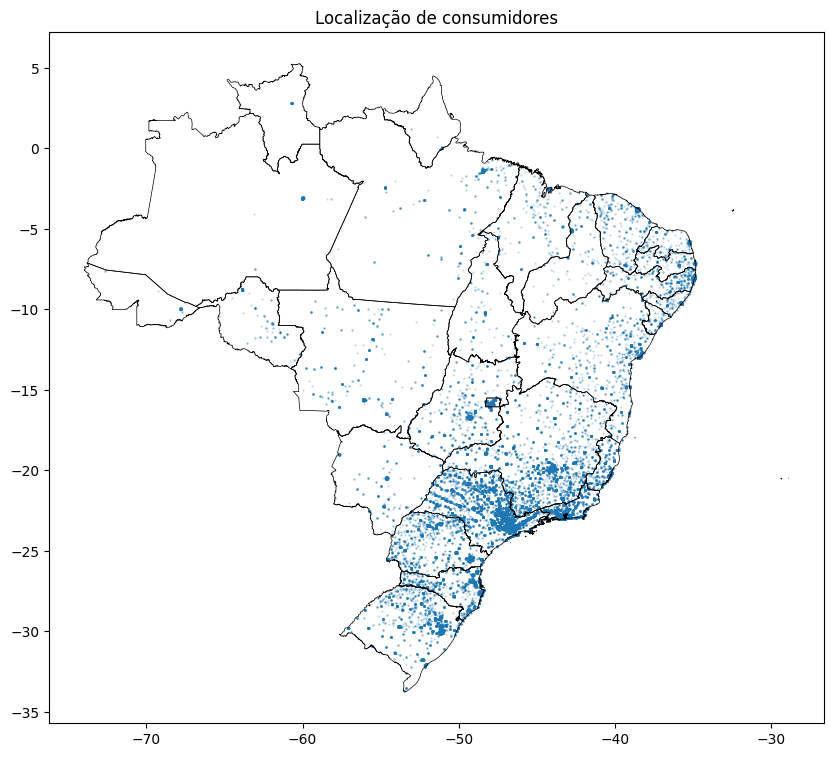

In [ ]:
# Essas linhas criam uma figura de tamanho 10x10 (em polegadas) e armazenam o objeto da figura em f e os eixos em ax. Em seguida, é plotado o contorno dos estados do Brasil
# utilizando o método boundary.plot() do DataFrame "state". Os estados são exibidos como linhas pretas com uma largura de linha de 0.5.
f, ax = plt.subplots(1, figsize=(10, 10))
state.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Essa linha cria um gráfico de dispersão dos pontos de localização dos clientes. O eixo x do gráfico é definido como a coluna 'customer_lng' do DataFrame "customer_data",
# enquanto o eixo y é definido como a coluna 'customer_lat'. Os pontos são exibidos como pequenos marcadores com tamanho 0.5 e transparência 0.2.
fig = plt.scatter(customer_data['customer_lng'], customer_data['customer_lat'], s=0.5, alpha=0.2)
plt.title('Localização de consumidores')
plt.show()

# Essas linhas criam uma visualização dos pontos de localização dos clientes utilizando um gráfico de hexbin.

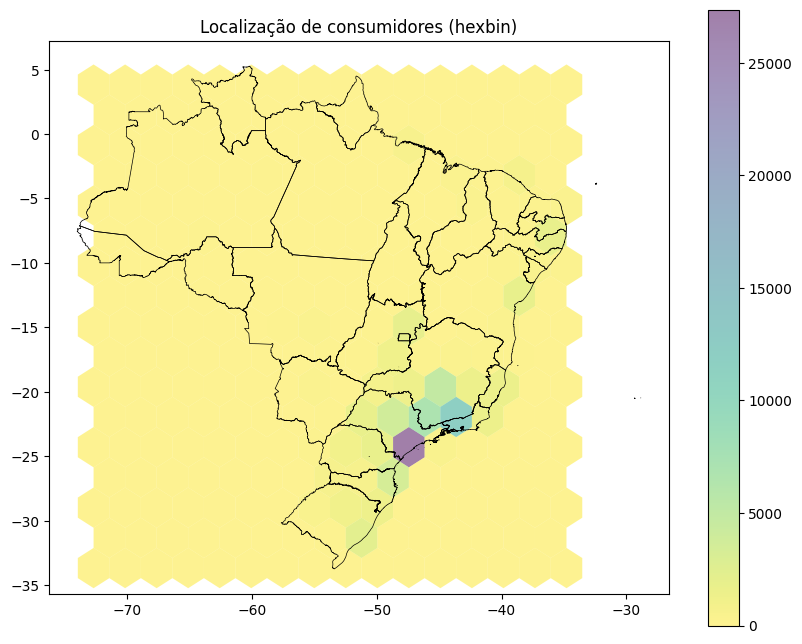

In [ ]:
# Essas linhas criam uma figura de tamanho 10x8 (em polegadas) e armazenam o objeto da figura em f e os eixos em ax.
# Em seguida, é plotado o contorno dos estados do Brasil utilizando o método boundary.plot() do DataFrame "state".
# Os estados são exibidos como linhas pretas com uma largura de linha de 0.5.
f, ax = plt.subplots(1, figsize=(10, 8))
state.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Essa linha cria um gráfico de hexbin dos pontos de localização dos clientes. Os eixos x e y do gráfico são definidos como as colunas
# 'customer_lng' e 'customer_lat' do DataFrame "customer_data". O parâmetro gridsize define o tamanho da grade hexagonal.
# Os pontos são agrupados nas células hexagonais e a cor e intensidade do hexágono são determinadas pela densidade dos pontos.
# Os hexágonos são exibidos com uma transparência de 0.5 e um mapa de cores 'viridis_r' (viridis invertido)
fig = plt.hexbin(customer_data['customer_lng'], customer_data['customer_lat'],
          gridsize=15, linewidths=0, alpha=0.5, cmap='viridis_r')
plt.title('Localização de consumidores (hexbin)')

plt.colorbar(fig)
plt.show()

# Essas linhas filtram o DataFrame df para manter apenas as linhas em que o estado do cliente é 'SP' (São Paulo). O resultado é armazenado novamente no DataFrame df.

In [ ]:
# Essa linha verifica se a coluna 'customer_state' do DataFrame df é igual a 'SP' e retorna um DataFrame contendo apenas as linhas em que essa condição é verdadeira.
df = df[df['customer_state'] == 'SP']
# Essa linha cria uma lista chamada customer_state com um único elemento, que é o valor 'SP'.
customer_state = ['SP']
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,customer_lat,customer_lng,payment_value,review_score,review_comment_title,review_comment_message,order_item_id,product_id,seller_id,price,freight_value,product_category_name,product_description_lenght,product_photos_qty,product_weight_g,seller_city,seller_state,seller_lat,seller_lng,transaction,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,-23.578333,-46.587123,18.12,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,268.0,4.0,500.0,maua,SP,-23.675223,-46.441038,38.71,housewares
1,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21 00:00:00,3e4fd73f1e86b135b9b121d6abbe9597,presidente venceslau,SP,-21.872573,-51.836167,356.12,1.0,NaN,"Inicialmente, na data da compra o produto era ...",1.0,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,339.00,17.12,utilidades_domesticas,664.0,6.0,14300.0,rio do sul,SC,-27.224769,-49.647870,356.12,housewares
3,e3447938231fb6ba2fee0231b51eca59,2c3642e1392097fb4af76a76fec16a46,delivered,2018-08-26 11:04:26,2018-08-26 11:15:29,2018-08-27 15:52:00,2018-08-28 21:06:31,2018-08-30 00:00:00,08de4d9507128e2ad419e26cc4f22b65,guarujá,SP,-23.985758,-46.242992,172.14,5.0,"Produto muito bonito, gos","Produto muito bonito, chegou no prazo correto ...",1.0,97f1396a5a1f7c07ba51784efdec44b8,955fee9216a65b617aa5c0531780ce60,160.00,12.14,utilidades_domesticas,1632.0,8.0,1400.0,são paulo,SP,-23.690136,-46.704876,172.14,housewares
4,af5b0604e113e1526593d505a26ef39d,b896b244963dc7543d400ad82d6710e0,delivered,2017-09-27 12:07:22,2017-09-27 12:26:02,2017-09-29 22:25:42,2017-09-30 17:13:01,2017-10-16 00:00:00,3d8614b1f25530eca12661dc8b10a2fb,são paulo,SP,-23.605983,-46.482517,28.62,1.0,NaN,"Boa noite, não recebi o escorredor de louça, C...",1.0,978859c6048ded0fa8bf3b9ea8236387,813348c996469b40f2e028d5429d3495,19.90,8.72,utilidades_domesticas,299.0,1.0,350.0,jundiai,SP,-23.207434,-46.881160,28.62,housewares
5,1c35ac660d7ef6691b25d20df3d6eccb,68c85132eb3b96fbe6cbddc09a568d24,delivered,2017-06-27 23:11:57,2017-06-27 23:35:09,2017-06-28 14:28:00,2017-06-29 10:16:35,2017-07-10 00:00:00,2df79c0c80c225d537833abb01a1a8ca,são paulo,SP,-23.596899,-46.600058,74.03,5.0,NaN,NaN,1.0,42a2c92a0979a949ca4ea89ec5c7b934,813348c996469b40f2e028d5429d3495,59.90,14.13,utilidades_domesticas,799.0,1.0,7000.0,jundiai,SP,-23.207434,-46.881160,74.03,housewares
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96230,1c3f752b9a4d09bf1e016439a427d5f8,7fe022a904d647429c6e08a8f34c9b22,delivered,2018-08-17 23:21:15,2018-08-17 23:35:14,2018-08-20 13:59:00,2018-08-21 19:36:43,2018-08-23 00:00:00,931a4a1a3e2cf8b4b4d33922f1469dbe,sao jose dos campos,SP,-23.208534,-45.900365,23.88,5.0,NaN,NaN,1.0,56a1efb30499b4dffd45c8d655199b11,55f7a3319d80f7fdf078b8f03e6725fe,16.49,7.39,artes_e_artesanato,778.0,2.0,100.0,osasco,SP,-23.565339,-46.787677,23.88,arts_and_craftmanship
96231,5065dc0da187940cd74472e443c1ff65,6235bf8cbae5a82b1c00e4c9d80b440d,delivered,2018-07-24 17:38:40,2018-07-24 17:50:10,2018-07-25 14:35:00,2018-07-26 20:31:50,2018-08-01 00:00:00,2c35043ad8f1d00f47150c486b585d8d,sao paulo,SP,-23.565200,-46.595082,145.70,3.0,NaN,Solicitei 220 volts e entregaram 110 volts. De...,1.0,b9976e9c22fb1540bd71d1bcd2989475,55f7a3319d80f7fdf078b8f03e6725fe,129.49,16.21,artes_e_artesanato,1611.0,7.0,2550.0,osasco,SP,-23.565339,-46.787677,

# Verificamos que existia inúmeras categorias e isso impactava nossa visualização e análise, uma vez que itens parecidos estavam em categorias diferentes, dessa forma criamos novas categorias agrupando as categorias anteriores, que eram similares, como subcatgoria

In [ ]:
# Nessas linhas, é criado um dicionário chamado category_mapping, que mapeia categorias para tipos.
# Cada chave do dicionário representa um tipo e o valor correspondente é uma lista de categorias relacionadas a esse tipo.

category_mapping = {
    'Fashion': ['fashion_bags_accessories', 'fashion_male_clothing', 'fashion_shoes', 'fashion_underwear_beach',
                'fashion_sport', 'fashion_childrens_clothes', 'watches_gifts'],
    'Technology': ['telephony', 'fixed_telephony', 'computers_accessories', 'computers', 'electronics',
                   'tablets_printing_image', 'consoles_games', 'audio', 'electronics'],
    'Home and Decor': ['housewares', 'bed_bath_table', 'furniture_decor', 'home_construction', 'furniture_bedroom',
                       'office_furniture', 'kitchen_dining_laundry_garden_furniture', 'furniture_living_room',
                       'furniture_mattress_and_upholstery', 'home_confort', 'garden_tools', 'flowers', 'la_cuisine'],
    'Tools': ['costruction_tools_garden', 'construction_tools_construction', 'home_construction',
              'construction_tools_safety', 'construction_tools_lights', 'signaling_and_security'],
    'Beauty and Health': ['health_beauty', 'perfumery', 'diapers_and_hygiene', 'baby'],
    'Business and Industry': ['agro_industry_and_commerce', 'industry_commerce_and_business'],
    'Food and Drinks': ['food', 'food_drink', 'drinks'],
    'Books, Audio and Image': ['books_general_interest', 'books_technical', 'books_imported', 'cds_dvds_musicals',
                               'music', 'cine_photo', 'dvds_blu_ray'],
    'Sports and Leisure': ['sports_leisure', 'musical_instruments', 'party_supplies', 'christmas_supplies', 'toys',
                         'cool_stuff', 'luggage_accessories', 'sports_leisure'],
    'Art': ['art', 'arts_and_craftmanship', 'stationery'],
    'Automotive': ['auto'],
    'Pet Shop': ['pet_shop'],
    'Home Appliances': ['home_appliances_2', 'small_appliances', 'home_appliances',
                        'small_appliances_home_oven_and_coffee', 'air_conditioning'],
    'Other': ['market_place']
}

# Em seguida, é adicionada uma nova coluna chamada "category" ao DataFrame df. Essa coluna é preenchida aplicando uma função lambda à coluna "product_category_name_english".
# A função lambda verifica se o valor da coluna está presente na lista de categorias de cada tipo no dicionário category_mapping.
# Se encontrar uma correspondência, o tipo correspondente é atribuído à nova coluna "category". Se não houver correspondência, é atribuído o valor None.
df['category'] = df['product_category_name_english'].apply(lambda x: next((k for k, v in category_mapping.items() if x in v), None))

# Essa linha renomeia a coluna "product_category_name_english" do DataFrame df para "subcategory". O método rename() é usado para renomear colunas em um DataFrame. O argumento columns é um dicionário que mapeia os nomes antigos das colunas para os novos nomes das colunas.

In [ ]:
df = df.rename(columns={'product_category_name_english':'subcategory'})
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,customer_lat,customer_lng,payment_value,review_score,review_comment_title,review_comment_message,order_item_id,product_id,seller_id,price,freight_value,product_category_name,product_description_lenght,product_photos_qty,product_weight_g,seller_city,seller_state,seller_lat,seller_lng,transaction,subcategory,category
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,-23.578333,-46.587123,18.12,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,268.0,4.0,500.0,maua,SP,-23.675223,-46.441038,38.71,housewares,Home and Decor
1,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21 00:00:00,3e4fd73f1e86b135b9b121d6abbe9597,presidente venceslau,SP,-21.872573,-51.836167,356.12,1.0,NaN,"Inicialmente, na data da compra o produto era ...",1.0,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,339.00,17.12,utilidades_domesticas,664.0,6.0,14300.0,rio do sul,SC,-27.224769,-49.647870,356.12,housewares,Home and Decor
3,e3447938231fb6ba2fee0231b51eca59,2c3642e1392097fb4af76a76fec16a46,delivered,2018-08-26 11:04:26,2018-08-26 11:15:29,2018-08-27 15:52:00,2018-08-28 21:06:31,2018-08-30 00:00:00,08de4d9507128e2ad419e26cc4f22b65,guarujá,SP,-23.985758,-46.242992,172.14,5.0,"Produto muito bonito, gos","Produto muito bonito, chegou no prazo correto ...",1.0,97f1396a5a1f7c07ba51784efdec44b8,955fee9216a65b617aa5c0531780ce60,160.00,12.14,utilidades_domesticas,1632.0,8.0,1400.0,são paulo,SP,-23.690136,-46.704876,172.14,housewares,Home and Decor
4,af5b0604e113e1526593d505a26ef39d,b896b244963dc7543d400ad82d6710e0,delivered,2017-09-27 12:07:22,2017-09-27 12:26:02,2017-09-29 22:25:42,2017-09-30 17:13:01,2017-10-16 00:00:00,3d8614b1f25530eca12661dc8b10a2fb,são paulo,SP,-23.605983,-46.482517,28.62,1.0,NaN,"Boa noite, não recebi o escorredor de louça, C...",1.0,978859c6048ded0fa8bf3b9ea8236387,813348c996469b40f2e028d5429d3495,19.90,8.72,utilidades_domesticas,299.0,1.0,350.0,jundiai,SP,-23.207434,-46.881160,28.62,housewares,Home and Decor
5,1c35ac660d7ef6691b25d20df3d6eccb,68c85132eb3b96fbe6cbddc09a568d24,delivered,2017-06-27 23:11:57,2017-06-27 23:35:09,2017-06-28 14:28:00,2017-06-29 10:16:35,2017-07-10 00:00:00,2df79c0c80c225d537833abb01a1a8ca,são paulo,SP,-23.596899,-46.600058,74.03,5.0,NaN,NaN,1.0,42a2c92a0979a949ca4ea89ec5c7b934,813348c996469b40f2e028d5429d3495,59.90,14.13,utilidades_domesticas,799.0,1.0,7000.0,jundiai,SP,-23.207434,-46.881160,74.03,housewares,Home and Decor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96230,1c3f752b9a4d09bf1e016439a427d5f8,7fe022a904d647429c6e08a8f34c9b22,delivered,2018-08-17 23:21:15,2018-08-17 23:35:14,2018-08-20 13:59:00,2018-08-21 19:36:43,2018-08-23 00:00:00,931a4a1a3e2cf8b4b4d33922f1469dbe,sao jose dos campos,SP,-23.208534,-45.900365,23.88,5.0,NaN,NaN,1.0,56a1efb30499b4dffd45c8d655199b11,55f7a3319d80f7fdf078b8f03e6725fe,16.49,7.39,artes_e_artesanato,778.0,2.0,100.0,osasco,SP,-23.565339,-46.787677,23.88,arts_and_craftmanship,Art
96231,5065dc0da187940cd74472e443c1ff65,6235bf8cbae5a82b1c00e4c9d80b440d,delivered,2018-07-24 17:38:40,2018-07-24 17:50:10,2018-07-25 14:35:00,2018-07-26 20:31:50,2018-08-01 00:00:00,2c35043ad8f1d00f47150c486b585d8d,sao paulo,SP,-23.565200,-46.595082,145.70,3.0,NaN,Solicitei 220 volts e entregaram 110 volts. De...,1.0,b9976e9c22fb1540bd71d1bcd2989475,55f7a3319d80f7fdf078b8f03e6725fe,129.49,1

## Posteriormente queremos fazer um merge desse dataframe com um dataframe contendo informações sobre o PIB de cada município do estado de São Paulo. Porém, foi identificado a necessidade de tratamento dos nomes das cidades existentes no dataframe, pelos seguintes motivos:

> Apesar da coluna ser de cidades de São Paulo, alguns nomes fazem referência a distritos dessas cidades, o que é uma problema uma que o dataframe de PIB per capita traz informações da cidade/município em si, então vamos renomear as linhas que trazem distritos com o nome da cidade

> Existem cidads que trazem ífen ou outros simbolos no nome, mesmo não tendo no original, dessa forma o df de PIB percapita não consegue encontrar a cidade correspondente, então estamos tratando esses casos também

> Nomes de cidades com erros de escrita, por exemplo, nomes que tem a letra "e" no meio escritas com "i" ou vice versa.

In [ ]:
cidades_simbolos = {
    'mogi-mirim': 'mogi mirim',
    'mogi-guacu': 'mogi guaçu',
    'biritiba-mirim': 'biritiba mirim'
}

distritos_cidades = {
    'bandeirantes d\'oeste': 'sud mennucci',
    'ibitiuva': 'pitangueiras',
    'agisse': 'rancharia',
    'maristela': 'laranjal paulista',
    'botelho': 'santa adelia',
    'venda branca': 'casa branca',
    'rechan': 'itapetininga',
    'holambra ii': 'paranapanema',
    'tecainda': 'martinopolis',
    'bonfim paulista': 'ribeirao preto',
    'primavera': 'rosana',
    'jacare': 'cabreuva',
    'tapinas': 'itapolis',
    'termas de ibira': 'ibira',
    'jamaica': 'dracena',
    'guarapua': 'dois corregos',
    'espigao': 'regente feijo',
    'irape': 'chavantes',
    'aparecida de sao manuel': 'sao manuel',
    'aparecida de monte alto': 'monte alto'
}

erros_nome_cidades = {
    'florinia': 'florinea',
    'embu': 'embu das artes'
}
# Mantendo os nomes dos distritos salvos
df['district'] = df['customer_city'].map(distritos_cidades)

# Substitui os símbolos no nome das cidades pelos nomes corretos especificados no dicionário cidades_simbolos.
df['customer_city'].replace(cidades_simbolos, inplace=True)
# Substitui os nomes de distritos pelas cidades corretas especificadas no dicionário distritos_cidades.
df['customer_city'].replace(distritos_cidades, inplace=True)
# Corrige erros de digitação no nome das cidades especificados no dicionário erros_nome_cidades.
df['customer_city'].replace(erros_nome_cidades, inplace=True)

# Definições 'manuais'
df.loc[df['customer_city'] == 'engenheiro balduino', 'district'] = 'engenheiro balduino'
df.loc[df['customer_city'] == 'engenheiro balduino', 'customer_city'] = 'monte aprazivel'
df.loc[df['customer_city'] == 'aparecida d oeste', 'customer_city'] = "aparecida d'oeste"
df.loc[df['customer_city'] == "santa barbara d'oeste", 'customer_city'] = "santa barbara d'oeste"
df.loc[df['customer_city'] == "estrela d'oeste", 'customer_city'] = "estrela d'oeste"
df.loc[df['customer_city'] == 'barao ataliba nogueira', 'district'] = 'barao ataliba nogueira'
df.loc[df['customer_city'] == 'barao ataliba nogueira', 'customer_city'] = "itapira"
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,customer_lat,customer_lng,payment_value,review_score,review_comment_title,review_comment_message,order_item_id,product_id,seller_id,price,freight_value,product_category_name,product_description_lenght,product_photos_qty,product_weight_g,seller_city,seller_state,seller_lat,seller_lng,transaction,subcategory,category,district
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,-23.578333,-46.587123,18.12,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,268.0,4.0,500.0,maua,SP,-23.675223,-46.441038,38.71,housewares,Home and Decor,NaN
1,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21 00:00:00,3e4fd73f1e86b135b9b121d6abbe9597,presidente venceslau,SP,-21.872573,-51.836167,356.12,1.0,NaN,"Inicialmente, na data da compra o produto era ...",1.0,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,339.00,17.12,utilidades_domesticas,664.0,6.0,14300.0,rio do sul,SC,-27.224769,-49.647870,356.12,housewares,Home and Decor,NaN
3,e3447938231fb6ba2fee0231b51eca59,2c3642e1392097fb4af76a76fec16a46,delivered,2018-08-26 11:04:26,2018-08-26 11:15:29,2018-08-27 15:52:00,2018-08-28 21:06:31,2018-08-30 00:00:00,08de4d9507128e2ad419e26cc4f22b65,guarujá,SP,-23.985758,-46.242992,172.14,5.0,"Produto muito bonito, gos","Produto muito bonito, chegou no prazo correto ...",1.0,97f1396a5a1f7c07ba51784efdec44b8,955fee9216a65b617aa5c0531780ce60,160.00,12.14,utilidades_domesticas,1632.0,8.0,1400.0,são paulo,SP,-23.690136,-46.704876,172.14,housewares,Home and Decor,NaN
4,af5b0604e113e1526593d505a26ef39d,b896b244963dc7543d400ad82d6710e0,delivered,2017-09-27 12:07:22,2017-09-27 12:26:02,2017-09-29 22:25:42,2017-09-30 17:13:01,2017-10-16 00:00:00,3d8614b1f25530eca12661dc8b10a2fb,são paulo,SP,-23.605983,-46.482517,28.62,1.0,NaN,"Boa noite, não recebi o escorredor de louça, C...",1.0,978859c6048ded0fa8bf3b9ea8236387,813348c996469b40f2e028d5429d3495,19.90,8.72,utilidades_domesticas,299.0,1.0,350.0,jundiai,SP,-23.207434,-46.881160,28.62,housewares,Home and Decor,NaN
5,1c35ac660d7ef6691b25d20df3d6eccb,68c85132eb3b96fbe6cbddc09a568d24,delivered,2017-06-27 23:11:57,2017-06-27 23:35:09,2017-06-28 14:28:00,2017-06-29 10:16:35,2017-07-10 00:00:00,2df79c0c80c225d537833abb01a1a8ca,são paulo,SP,-23.596899,-46.600058,74.03,5.0,NaN,NaN,1.0,42a2c92a0979a949ca4ea89ec5c7b934,813348c996469b40f2e028d5429d3495,59.90,14.13,utilidades_domesticas,799.0,1.0,7000.0,jundiai,SP,-23.207434,-46.881160,74.03,housewares,Home and Decor,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96230,1c3f752b9a4d09bf1e016439a427d5f8,7fe022a904d647429c6e08a8f34c9b22,delivered,2018-08-17 23:21:15,2018-08-17 23:35:14,2018-08-20 13:59:00,2018-08-21 19:36:43,2018-08-23 00:00:00,931a4a1a3e2cf8b4b4d33922f1469dbe,sao jose dos campos,SP,-23.208534,-45.900365,23.88,5.0,NaN,NaN,1.0,56a1efb30499b4dffd45c8d655199b11,55f7a3319d80f7fdf078b8f03e6725fe,16.49,7.39,artes_e_artesanato,778.0,2.0,100.0,osasco,SP,-23.565339,-46.787677,23.88,arts_and_craftmanship,Art,NaN
96231,5065dc0da187940cd74472e443c1ff65,6235bf8cbae5a82b1c00e4c9d80b440d,delivered,2018-07-24 17:38:40,2018-07-24 17:50:10,2018-07-25 14:35:00,2018-07-26 20:31:50,2018-08-01 00:00:00,2c35043ad8f1d00f47150c486b585d8d,sao paulo,SP,-23.565200,-46.595082,145.70,3.0,NaN,Solicitei 220 volts e entregaram 110 volts. De...,1.0,b9976e9c22fb1540bd71d1bcd2989475,55f7

# O código carrega o arquivo "pib_sp.csv" que contém dados do Produto Interno Bruto (PIB) per capita do estado de São Paulo em 2020. Em seguida, ele realiza algumas transformações nos nomes das colunas do DataFrame df_pib_sp.

In [ ]:
df_pib_sp = pd.read_csv("input/pib_sp.csv") #2020

# Remover as aspas e espaços em branco extras dos nomes das colunas, garantindo que os nomes estejam formatados corretamente.
df_pib_sp.columns = df_pib_sp.columns.str.replace('"', '').str.strip()
df_pib_sp

,Local,PIB per capita
0,Adamantina,35788.26
1,Adolfo,38464.09
2,Aguaí,31446.28
3,Águas da Prata,22718.42
4,Águas de Lindóia,26418.38
...,...,...
640,Votorantim,27713.57
641,Votuporanga,35390.26
642,Zacarias,41074.60
643,Chavantes,19174.98


# O código define os thresholds para classificar as faixas de PIB per capita, cria um mapa coroplético do estado de São Paulo com base nos dados do PIB per capita por município e plota o mapa com a legenda correspondente.

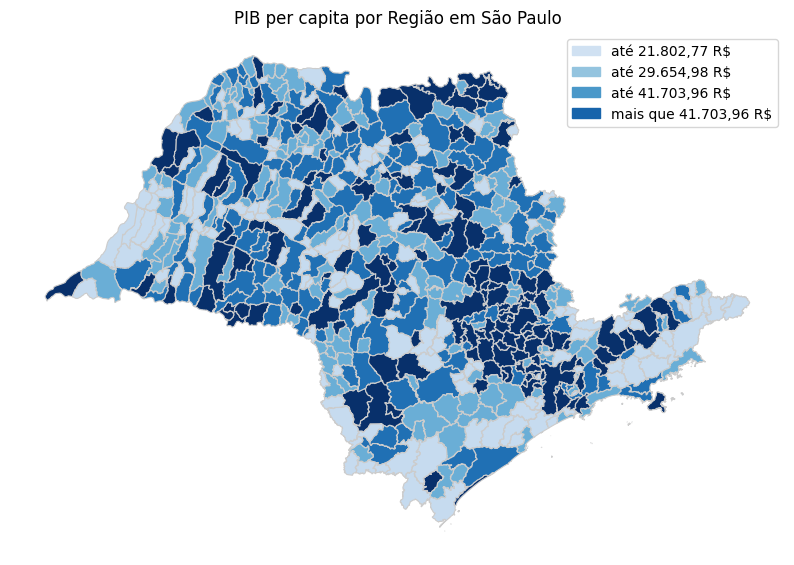

In [ ]:
# Definindo os thresholds
thresholds = [0, 21802.77, 29654.98, 41703.96]

# Neste código, é criado um DataFrame chamado sp que contém os dados geográficos dos municípios de São Paulo.
sp = gpd.read_file('https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/UFs/SP/SP_Municipios_2022.zip')

# Em seguida, os dados do DataFrame df_pib_sp são juntados ao DataFrame sp com base no nome dos municípios. Essa junção é feita usando o método join().
merged = sp.set_index('NM_MUN').join(df_pib_sp.set_index('Local'))

# Plotagem do mapa coroplético
fig, ax = plt.subplots(figsize=(10, 10))  # Define o tamanho da figura
merged.plot(column='PIB per capita', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, scheme='user_defined', classification_kwds={'bins': thresholds})

# Removendo os eixos
ax.axis('off')

# Configurando a legenda
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., -0.2, 1., 0.1))  # Posiciona a legenda abaixo do gráfico
leg.set_title('PIB per capita')  # Título da legenda

# Descrição dos intervalos
labels = ['até 21.802,77 R$', 'até 29.654,98 R$', 'até 41.703,96 R$', 'mais que 41.703,96 R$']

# Cores correspondentes aos intervalos do mapa
colors = plt.cm.Blues([0.2, 0.4, 0.6, 0.8])

# Configurando a legenda com cores
custom_patches = [Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

ax.legend(handles=custom_patches)

plt.title('PIB per capita por Região em São Paulo')
plt.show()


In [ ]:
#No DataFrame df_pib_sp, uma nova coluna chamada "Local2" foi adicionada com os valores da coluna "Local". Isso foi feito utilizando o método assign().
df_pib_sp = df_pib_sp.assign(
    Local2=df_pib_sp['Local']
)

# Em seguida, a coluna "Local" foi modificada para deixar todos os valores em letras minúsculas e sem caracteres acentuados.
# Para isso, foi utilizada a função unidecode() do pacote unidecode para remover os acentos e a função lower() para converter os valores para letras minúsculas.
# O resultado dessa modificação foi atribuído novamente à coluna "Local".
df_pib_sp['Local'] = df_pib_sp['Local'].apply(lambda x: unidecode(x).lower())

# A coluna "Local" também foi renomeada para "customer_city" e a coluna "PIB per capita" foi renomeada para "pib". Isso foi feito utilizando o método rename().
df_pib_sp = df_pib_sp.rename(columns={
    'Local': 'customer_city',
    'PIB per capita': 'pib'
})

# No DataFrame df, a coluna "customer_city" também passou pelo mesmo processo de remover caracteres acentuados e converter para letras minúsculas.
# Isso foi feito utilizando a função unidecode() e lower() dentro de uma função lambda aplicada à coluna "customer_city".
df['customer_city'] = df['customer_city'].apply(lambda x: unidecode(x).lower())

In [ ]:
# Para converter os valores da coluna "pib" para o tipo numérico. A opção errors='coerce' é utilizada para tratar valores inválidos, convertendo-os para NaN.
df_pib_sp['pib'] = pd.to_numeric(df_pib_sp['pib'], errors='coerce')

# Utilizado para substituir os valores ausentes (NaN) por um valor específico. Os valores ausentes são substituídos por 0.
df_pib_sp['pib'] = df_pib_sp['pib'].fillna(0)

# Formatar os valores da coluna "pib" com duas casas decimais. A formatação é feita utilizando a função '{:.2f}'.format(x), em que x representa cada valor da coluna "pib".

df_pib_sp['pib'] = df_pib_sp['pib'].apply(lambda x: '{:.2f}'.format(x))

In [ ]:
# df_merged conterá todas as colunas do DataFrame df e a coluna "pib" do DataFrame df_pib_sp será adicionada com base na correspondência dos valores da coluna "customer_city".
# Os registros que não tiverem correspondência na coluna de junção terão valores nulos (NaN) na coluna "pib".
df_merged = pd.merge(df, df_pib_sp, on='customer_city', how='left')
df_merged

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,customer_lat,customer_lng,payment_value,review_score,review_comment_title,review_comment_message,order_item_id,product_id,seller_id,price,freight_value,product_category_name,product_description_lenght,product_photos_qty,product_weight_g,seller_city,seller_state,seller_lat,seller_lng,transaction,subcategory,category,district,pib,Local2
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,-23.578333,-46.587123,18.12,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,268.0,4.0,500.0,maua,SP,-23.675223,-46.441038,38.71,housewares,Home and Decor,NaN,60750.09,São Paulo
1,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21 00:00:00,3e4fd73f1e86b135b9b121d6abbe9597,presidente venceslau,SP,-21.872573,-51.836167,356.12,1.0,NaN,"Inicialmente, na data da compra o produto era ...",1.0,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,339.00,17.12,utilidades_domesticas,664.0,6.0,14300.0,rio do sul,SC,-27.224769,-49.647870,356.12,housewares,Home and Decor,NaN,19800.54,Presidente Venceslau
2,e3447938231fb6ba2fee0231b51eca59,2c3642e1392097fb4af76a76fec16a46,delivered,2018-08-26 11:04:26,2018-08-26 11:15:29,2018-08-27 15:52:00,2018-08-28 21:06:31,2018-08-30 00:00:00,08de4d9507128e2ad419e26cc4f22b65,guaruja,SP,-23.985758,-46.242992,172.14,5.0,"Produto muito bonito, gos","Produto muito bonito, chegou no prazo correto ...",1.0,97f1396a5a1f7c07ba51784efdec44b8,955fee9216a65b617aa5c0531780ce60,160.00,12.14,utilidades_domesticas,1632.0,8.0,1400.0,são paulo,SP,-23.690136,-46.704876,172.14,housewares,Home and Decor,NaN,28707.73,Guarujá
3,af5b0604e113e1526593d505a26ef39d,b896b244963dc7543d400ad82d6710e0,delivered,2017-09-27 12:07:22,2017-09-27 12:26:02,2017-09-29 22:25:42,2017-09-30 17:13:01,2017-10-16 00:00:00,3d8614b1f25530eca12661dc8b10a2fb,sao paulo,SP,-23.605983,-46.482517,28.62,1.0,NaN,"Boa noite, não recebi o escorredor de louça, C...",1.0,978859c6048ded0fa8bf3b9ea8236387,813348c996469b40f2e028d5429d3495,19.90,8.72,utilidades_domesticas,299.0,1.0,350.0,jundiai,SP,-23.207434,-46.881160,28.62,housewares,Home and Decor,NaN,60750.09,São Paulo
4,1c35ac660d7ef6691b25d20df3d6eccb,68c85132eb3b96fbe6cbddc09a568d24,delivered,2017-06-27 23:11:57,2017-06-27 23:35:09,2017-06-28 14:28:00,2017-06-29 10:16:35,2017-07-10 00:00:00,2df79c0c80c225d537833abb01a1a8ca,sao paulo,SP,-23.596899,-46.600058,74.03,5.0,NaN,NaN,1.0,42a2c92a0979a949ca4ea89ec5c7b934,813348c996469b40f2e028d5429d3495,59.90,14.13,utilidades_domesticas,799.0,1.0,7000.0,jundiai,SP,-23.207434,-46.881160,74.03,housewares,Home and Decor,NaN,60750.09,São Paulo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40556,1c3f752b9a4d09bf1e016439a427d5f8,7fe022a904d647429c6e08a8f34c9b22,delivered,2018-08-17 23:21:15,2018-08-17 23:35:14,2018-08-20 13:59:00,2018-08-21 19:36:43,2018-08-23 00:00:00,931a4a1a3e2cf8b4b4d33922f1469dbe,sao jose dos campos,SP,-23.208534,-45.900365,23.88,5.0,NaN,NaN,1.0,56a1efb30499b4dffd45c8d655199b11,55f7a3319d80f7fdf078b8f03e6725fe,16.49,7.39,artes_e_artesanato,778.0,2.0,100.0,osasco,SP,-23.565339,-46.787677,23.88,arts_and_craftmanship,Art,NaN,53646.74,São José dos Campos
40557,5065dc0da187940cd74472e443c1ff65,6235bf8cbae5a82b1c00e4c9d80b440d,delivered,2018-07-24 17:38:40,2018-07-24 17:50:10,2018-07-25 14:35:00,2018-07-26 20:31:50,2018-08-01 00:00:00,2c35043ad8f1d00f47150c

In [ ]:
# Remove as colunas 'customer_city' e 'product_category_name' do DataFrame df_sp usando o método drop().
df_sp = df_merged.drop(columns=['customer_city', 'product_category_name'])

In [ ]:
# Renomeia a coluna 'Local2' do DataFrame df_sp para 'customer_city'.
df_sp = df_sp.rename(columns={
    'Local2': 'customer_city'
})

In [ ]:
# cria uma nova coluna chamada 'geometry' no DataFrame df_sp que contém os pontos de latitude e longitude convertidos em objetos de geometria do GeoPandas.
df_sp['geometry'] = gpd.points_from_xy(df['customer_lng'], df['customer_lat'])

# Cria um novo GeoDataFrame chamado gdf a partir do DataFrame df_sp, usando a coluna 'geometry' como a coluna de geometria.
gdf = gpd.GeoDataFrame(df_sp, geometry='geometry')

# Define o sistema de coordenadas do GeoDataFrame como EPSG 4326, que é a projeção de coordenadas geográficas WGS84.
gdf.crs = 'EPSG:4326'
gdf

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,customer_lat,customer_lng,payment_value,review_score,review_comment_title,review_comment_message,order_item_id,product_id,seller_id,price,freight_value,product_description_lenght,product_photos_qty,product_weight_g,seller_city,seller_state,seller_lat,seller_lng,transaction,subcategory,category,district,pib,customer_city,geometry
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,SP,-23.578333,-46.587123,18.12,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,268.0,4.0,500.0,maua,SP,-23.675223,-46.441038,38.71,housewares,Home and Decor,NaN,60750.09,São Paulo,POINT (-46.58712 -23.57833)
1,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21 00:00:00,3e4fd73f1e86b135b9b121d6abbe9597,SP,-21.872573,-51.836167,356.12,1.0,NaN,"Inicialmente, na data da compra o produto era ...",1.0,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,339.00,17.12,664.0,6.0,14300.0,rio do sul,SC,-27.224769,-49.647870,356.12,housewares,Home and Decor,NaN,19800.54,Presidente Venceslau,POINT (-51.83617 -21.87257)
2,e3447938231fb6ba2fee0231b51eca59,2c3642e1392097fb4af76a76fec16a46,delivered,2018-08-26 11:04:26,2018-08-26 11:15:29,2018-08-27 15:52:00,2018-08-28 21:06:31,2018-08-30 00:00:00,08de4d9507128e2ad419e26cc4f22b65,SP,-23.985758,-46.242992,172.14,5.0,"Produto muito bonito, gos","Produto muito bonito, chegou no prazo correto ...",1.0,97f1396a5a1f7c07ba51784efdec44b8,955fee9216a65b617aa5c0531780ce60,160.00,12.14,1632.0,8.0,1400.0,são paulo,SP,-23.690136,-46.704876,172.14,housewares,Home and Decor,NaN,28707.73,Guarujá,POINT (-46.24299 -23.98576)
3,af5b0604e113e1526593d505a26ef39d,b896b244963dc7543d400ad82d6710e0,delivered,2017-09-27 12:07:22,2017-09-27 12:26:02,2017-09-29 22:25:42,2017-09-30 17:13:01,2017-10-16 00:00:00,3d8614b1f25530eca12661dc8b10a2fb,SP,-23.605983,-46.482517,28.62,1.0,NaN,"Boa noite, não recebi o escorredor de louça, C...",1.0,978859c6048ded0fa8bf3b9ea8236387,813348c996469b40f2e028d5429d3495,19.90,8.72,299.0,1.0,350.0,jundiai,SP,-23.207434,-46.881160,28.62,housewares,Home and Decor,NaN,60750.09,São Paulo,POINT (-46.48252 -23.60598)
4,1c35ac660d7ef6691b25d20df3d6eccb,68c85132eb3b96fbe6cbddc09a568d24,delivered,2017-06-27 23:11:57,2017-06-27 23:35:09,2017-06-28 14:28:00,2017-06-29 10:16:35,2017-07-10 00:00:00,2df79c0c80c225d537833abb01a1a8ca,SP,-23.596899,-46.600058,74.03,5.0,NaN,NaN,1.0,42a2c92a0979a949ca4ea89ec5c7b934,813348c996469b40f2e028d5429d3495,59.90,14.13,799.0,1.0,7000.0,jundiai,SP,-23.207434,-46.881160,74.03,housewares,Home and Decor,NaN,60750.09,São Paulo,POINT (-46.60006 -23.59690)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40556,1c3f752b9a4d09bf1e016439a427d5f8,7fe022a904d647429c6e08a8f34c9b22,delivered,2018-08-17 23:21:15,2018-08-17 23:35:14,2018-08-20 13:59:00,2018-08-21 19:36:43,2018-08-23 00:00:00,931a4a1a3e2cf8b4b4d33922f1469dbe,SP,-23.208534,-45.900365,23.88,5.0,NaN,NaN,1.0,56a1efb30499b4dffd45c8d655199b11,55f7a3319d80f7fdf078b8f03e6725fe,16.49,7.39,778.0,2.0,100.0,osasco,SP,-23.565339,-46.787677,23.88,arts_and_craftmanship,Art,NaN,53646.74,São José dos Campos,POINT (-45.90037 -23.20853)
40557,5065dc0da187940cd74472e443c1ff65,6235bf8cbae5a82b1c00e4c9d80b440d,delivered,2018-07-24 17:38:40,2018-07-24 17:50:10,2018-07-25 14:35:00,2018-07-26 20:31:50,2018-08-01 00:00:00,2c35043ad8f1d00f47150c486b585d8d,SP,-23.565200,-46.595082,145.70,3.0,NaN,Solicitei 220

In [ ]:
# Converte a coluna 'pib' para tipo numérico
gdf['pib'] = pd.to_numeric(gdf['pib'], errors='coerce')

# Verifica se há valores inválidos (NaN) após a conversão
invalid_values = gdf['pib'].isna().sum()
if invalid_values > 0:
    print(f"A coluna 'pib' contém {invalid_values} valores inválidos.")

# Valor máximo e mínimo
vmax = gdf['pib'].max()
vmin = gdf['pib'].min()
print(vmax)
print(vmin)

A coluna 'pib' contém 14 valores inválidos.
357104.23
9696.12


In [ ]:
# Remover as linhas que contêm valores inválidos na coluna 'pib'
gdf.dropna(subset=['pib'], inplace=True)

In [ ]:
# Valor máximo e mínimo
vmax = gdf['pib'].max()
vmin = gdf['pib'].min()
print(vmax)
print(vmin)

357104.23
9696.12


In [ ]:
# Agrupando as estatísticas por categoria, calcula as estatísticas para a coluna 'payment_value', incluindo a média, mediana, soma, valor mínimo e valor máximo.
stats = gdf.groupby("category").agg({
    "geometry": "count",
    "payment_value": ["mean", "median", "sum", "min", "max"]
})

# Em seguida, os resultados são classificados em ordem decrescente com base na contagem de geometrias ('geometry') para cada categoria.
stats = stats.sort_values(("geometry", "count"), ascending=False)
stats

geometry payment_value                              \
                          count          mean   median         sum    min   
category                                                                    
Home and Decor            12265    134.298567   97.870  1647171.92   0.01   
Sports and Leisure         6832    146.307800  102.655   999574.89   0.01   
Beauty and Health          6297    137.607899   90.050   866379.33   0.03   
Technology                 5854    126.264862   60.700   739154.50   0.01   
Fashion                    3092    173.169279  105.485   535439.41   0.27   
Automotive                 1598    147.564387   86.575   235807.89   2.08   
Art                        1075    112.328409   92.570   120753.04   5.36   
Home Appliances             847    225.823766  100.110   191272.73   9.64   
Pet Shop                    749    134.224059  111.320   100533.82   0.26   
Tools                       637    191.823218  109.840   122191.39   1.48   
Food and Drinks             518     73.383591   57.430    38012.70   4.35   
Books, Audio and Image      420    103.892952   65.620    43635.04   3.86   
Business and Industry       199    239.948492  124.980    47749.75  20.39   
Other                       102    106.171176   72.215    10829.46   1.22   

                                 
                            max  
category                         
Home and Decor          2818.74  
Sports and Leisure      4513.32  
Beauty and Health       2938.17  
Technology              3526.46  
Fashion                 4016.91  
Automotive              2322.32  
Art                     6726.66  
Home Appliances         4764.34  
Pet Shop                1291.39  
Tools                   2328.40  
Food and Drinks          643.84  
Books, Audio and Image  1438.23  
Business and Industry   2467.33  
Other                    396.90

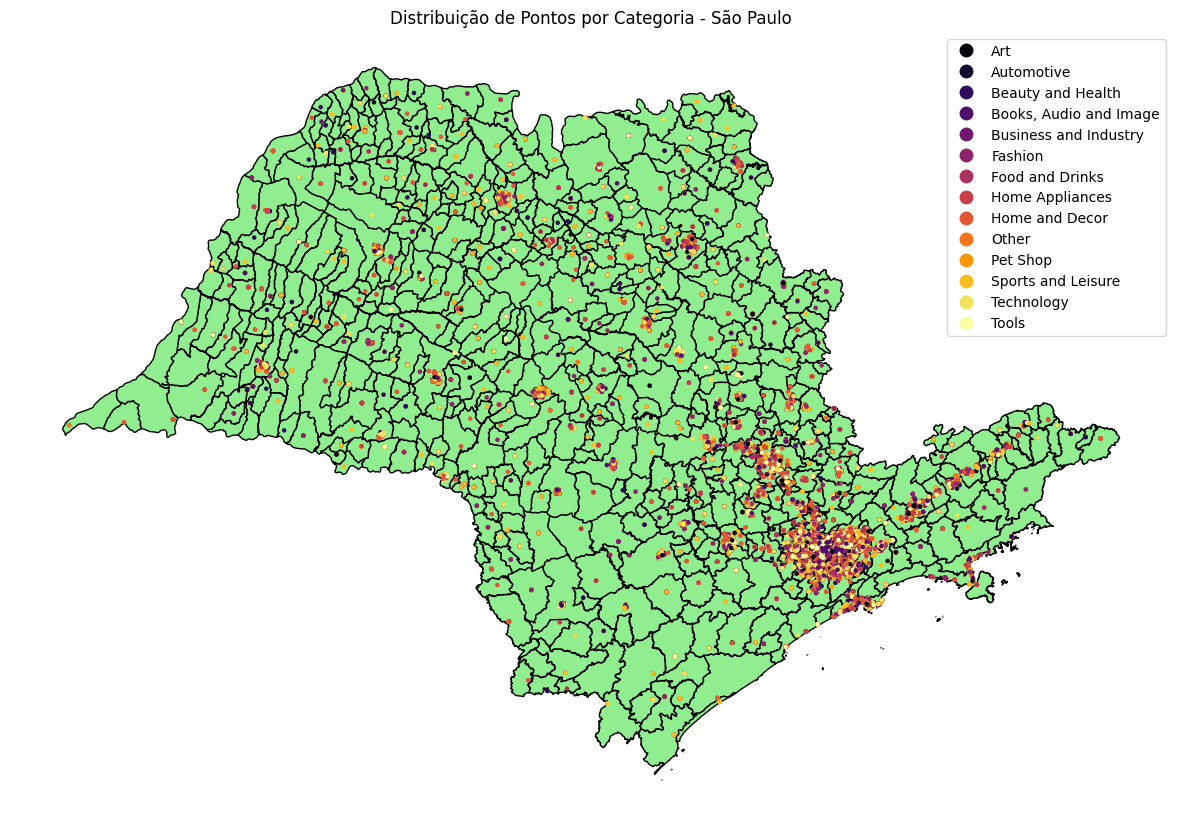

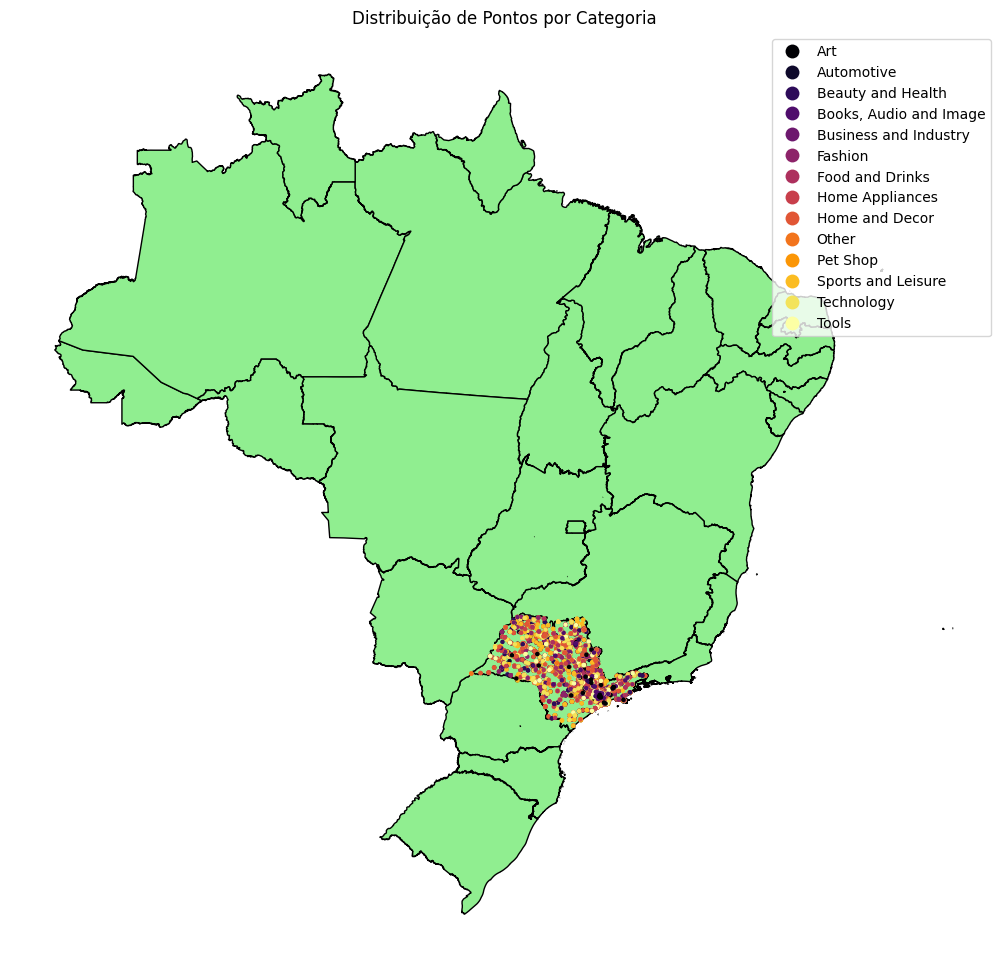

In [ ]:
# Carregar o shapefile do Brasil
brasil = gpd.read_file('https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_UF_2022.zip')


# Carregar o shapefile de São Paulo
sp = gpd.read_file('https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/UFs/SP/SP_Municipios_2022.zip')

# Definir o sistema de referência do shapefile de São Paulo
sp.crs = 'EPSG:4326'

# Filtrar os pontos que estão dentro de São Paulo
gdf_sp = gpd.sjoin(gdf, sp, predicate='within')

# Plotar os pontos filtrados sobre a malha municipal de São Paulo
fig, ax = plt.subplots(figsize=(15, 12))
sp.plot(ax=ax, color='lightgreen', edgecolor='black')
gdf_sp.plot(ax=ax, markersize=5, column='category', cmap='inferno', legend=True)
ax.axis('off')
plt.title('Distribuição de Pontos por Categoria - São Paulo')
plt.show()

# Plotar a malha municipal do Brasil
fig, ax = plt.subplots(figsize=(15, 12))
brasil.plot(ax=ax, color='lightgreen', edgecolor='black')

# Plotar os pontos sobre a malha municipal com cores diferentes por categoria
gdf.plot(ax=ax, markersize=5, column='category', cmap='inferno', legend=True)

# Remover os eixos
ax.axis('off')

# Adicionar um título
plt.title('Distribuição de Pontos por Categoria')

# Exibir o gráfico
plt.show()


In [ ]:
import folium
from folium.plugins import MarkerCluster
import locale

# Definindo a localidade como pt_BR para formatar os valores monetários
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# Criando um novo DataFrame com as ocorrências únicas das cidades
unique_cities = gdf.drop_duplicates('customer_city')[['customer_city', 'pib', 'customer_lat', 'customer_lng', 'category', 'subcategory']]

# Agrupando os dados do novo DataFrame pelo nome da cidade e calculando o total do PIB
pib_por_cidade = unique_cities.groupby('customer_city')['pib'].sum()

# Realizando o merge com a coluna 'customer_lat'
sp = sp.merge(unique_cities[['customer_city', 'customer_lat', 'customer_lng', 'pib', 'category', 'subcategory']], left_on='NM_MUN', right_on='customer_city')

# Encontrando a categoria e a subcategoria mais compradas para cada cidade no DataFrame 'sp'
categoria_mais_comprada_por_cidade = gdf.groupby('customer_city')['category'].agg(lambda x: x.value_counts().idxmax())
subcategoria_mais_comprada_por_cidade = gdf.groupby('customer_city')['subcategory'].agg(lambda x: x.value_counts().idxmax())

# Calculando a média da coluna 'transaction' por subcategoria
media_transacao_subcategoria = gdf.groupby(['customer_city', 'subcategory'])['transaction'].mean().reset_index()

# Criando o mapa
m = folium.Map(location=[-23.550520, -46.633308], zoom_start=10)

# Criando um marcador de cluster
marker_cluster = MarkerCluster().add_to(m)

# Adicionando as informações ao mapa
for index, row in sp.iterrows():
    lat = row['customer_lat']
    lng = row['customer_lng']
    cidade = row['NM_MUN']
    pib = locale.currency(row['pib'], grouping=True)
    categoria = categoria_mais_comprada_por_cidade.get(cidade)
    subcategoria = subcategoria_mais_comprada_por_cidade.get(cidade)
    media_transacao = media_transacao_subcategoria[(media_transacao_subcategoria['customer_city'] == cidade) & (media_transacao_subcategoria['subcategory'] == subcategoria)]['transaction'].values[0]
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        tooltip=f"Cidade: {cidade}<br>PIB: {pib}<br>Categoria mais comprada: {categoria}<br>Subcategoria mais comprada: {subcategoria}<br>Média de transação para a subcategoria: {locale.currency(media_transacao, grouping=True)}"
    ).add_to(marker_cluster)

# Exibindo o mapa interativo
m
